In [2]:
# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import random
import os
import sys

# Add path to Bayesian services
sys.path.append('../services')  # Adjust as needed

# Import ONLY what we need - no regimes!
from db_service import load_market_data, load_detected_change_points

# Reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Setup complete!")

2026-02-17 10:56:39.937332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Setup complete!


In [3]:
# Cell 2: Load Data - Change Points Only!

print("📊 Loading data...")

# Load price data
market_data = load_market_data()

# Load CHANGE POINTS (not regimes!)
change_points = load_detected_change_points()

print(f"\n✅ Loaded:")
print(f"   Market Data: {len(market_data)} rows")
print(f"   Date Range: {market_data.index.min()} to {market_data.index.max()}")
print(f"   Change Points: {len(change_points)} crises detected")
print(f"   Avg Confidence: {change_points['detection_confidence'].mean():.3f}")

# Show detected crises
print(f"\n📅 Detected Crises:")
for i, cp in change_points.iterrows():
    vol_ratio = cp['volatility_crisis'] / cp['volatility_pre']
    print(f"   {i+1}. {cp['crisis_start_date'].date()} to {cp['crisis_end_date'].date()} "
          f"(Vol: {vol_ratio:.2f}x, Conf: {cp['detection_confidence']:.3f})")

📊 Loading data...


INFO:db_service:✅ Loaded 4615 rows from market_data.
INFO:db_service:✅ Loaded 11 detected change points.



✅ Loaded:
   Market Data: 4615 rows
   Date Range: 2007-07-30 00:00:00 to 2026-02-13 00:00:00
   Change Points: 11 crises detected
   Avg Confidence: 0.892

📅 Detected Crises:
   1. 2008-09-11 to 2009-04-03 (Vol: 2.06x, Conf: 0.928)
   2. 2012-05-14 to 2012-11-09 (Vol: 1.59x, Conf: 0.874)
   3. 2013-12-06 to 2014-09-24 (Vol: 0.80x, Conf: 0.791)
   4. 2014-11-19 to 2015-04-16 (Vol: 2.82x, Conf: 0.765)
   5. 2015-12-28 to 2016-04-08 (Vol: 1.67x, Conf: 0.848)
   6. 2018-11-09 to 2019-01-15 (Vol: 2.04x, Conf: 0.938)
   7. 2019-05-20 to 2019-09-18 (Vol: 2.71x, Conf: 0.953)
   8. 2020-03-04 to 2020-06-08 (Vol: 4.14x, Conf: 0.957)
   9. 2023-09-26 to 2024-02-08 (Vol: 2.09x, Conf: 0.951)
   10. 2024-07-24 to 2024-11-15 (Vol: 1.73x, Conf: 0.876)
   11. 2025-03-31 to 2025-06-24 (Vol: 1.94x, Conf: 0.931)


In [4]:
# Cell 3: Feature Engineering from Change Points

print("\n🔧 Engineering features from change points...")

def engineer_change_point_features(market_data, change_points):
    """
    Create continuous features from sparse change point detections.

    Returns 8 features:
    1. days_since_last_crisis - Temporal distance to past
    2. last_crisis_intensity - Previous crisis severity
    3. days_to_next_crisis - Temporal distance to future
    4. in_crisis - Binary current state
    5. crisis_progress - Position within current crisis (0-1)
    6. current_crisis_intensity - Real-time severity
    7. detection_confidence - Quality of current detection
    8. crisis_density - Number of crises in past year
    """
    features_list = []

    for date in market_data.index:
        features = {}

        # Identify relevant crises
        past_crises = change_points[change_points['crisis_end_date'] < date]
        future_crises = change_points[change_points['crisis_start_date'] > date]
        active_crisis = change_points[
            (change_points['crisis_start_date'] <= date) &
            (change_points['crisis_end_date'] >= date)
        ]

        # Feature 1-2: Last crisis information
        if len(past_crises) > 0:
            last_crisis = past_crises.iloc[-1]
            features['days_since_last_crisis'] = (date - last_crisis['crisis_end_date']).days
            features['last_crisis_intensity'] = float(
                last_crisis['volatility_crisis'] / last_crisis['volatility_pre']
            )
        else:
            features['days_since_last_crisis'] = 9999  # No previous crisis
            features['last_crisis_intensity'] = 1.0

        # Feature 3: Next crisis distance
        if len(future_crises) > 0:
            next_crisis = future_crises.iloc[0]
            features['days_to_next_crisis'] = (next_crisis['crisis_start_date'] - date).days
        else:
            features['days_to_next_crisis'] = 9999  # No future crisis

        # Feature 4-7: Current crisis state
        if len(active_crisis) > 0:
            crisis = active_crisis.iloc[0]
            total_days = (crisis['crisis_end_date'] - crisis['crisis_start_date']).days
            elapsed_days = (date - crisis['crisis_start_date']).days

            features['in_crisis'] = 1.0
            features['crisis_progress'] = float(elapsed_days / max(total_days, 1))
            features['current_crisis_intensity'] = float(
                crisis['volatility_crisis'] / crisis['volatility_pre']
            )
            features['detection_confidence'] = float(crisis['detection_confidence'])
        else:
            features['in_crisis'] = 0.0
            features['crisis_progress'] = 0.0
            features['current_crisis_intensity'] = 1.0
            features['detection_confidence'] = 0.0

        # Feature 8: Crisis density (how volatile is this period?)
        one_year_ago = date - pd.Timedelta(days=365)
        recent_crises = change_points[
            (change_points['crisis_end_date'] >= one_year_ago) &
            (change_points['crisis_start_date'] <= date)
        ]
        features['crisis_density'] = float(len(recent_crises))

        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list, index=market_data.index)

    return features_df

# Create features
change_point_features = engineer_change_point_features(market_data, change_points)

# Merge with price data
df = market_data[['price']].copy()
df = df.join(change_point_features)

print(f"\n✅ Feature engineering complete!")
print(f"   Total features: {len(change_point_features.columns)}")
print(f"   Features: {list(change_point_features.columns)}")

# Show sample
print(f"\n📊 Sample (row 1000):")
sample = df.iloc[1000]
print(f"   Date: {df.index[1000]}")
print(f"   Price: ${sample['price']:.2f}")
print(f"   Days since last crisis: {sample['days_since_last_crisis']:.0f}")
print(f"   In crisis: {sample['in_crisis']:.0f}")
print(f"   Crisis density: {sample['crisis_density']:.0f}")


🔧 Engineering features from change points...

✅ Feature engineering complete!
   Total features: 8
   Features: ['days_since_last_crisis', 'last_crisis_intensity', 'days_to_next_crisis', 'in_crisis', 'crisis_progress', 'current_crisis_intensity', 'detection_confidence', 'crisis_density']

📊 Sample (row 1000):
   Date: 2011-08-30 00:00:00
   Price: $114.02
   Days since last crisis: 879
   In crisis: 0
   Crisis density: 0


📊 Split:
   Training: 2007-07-30 → 2024-12-31 (4333 days)
   Testing:  2025-01-02 → 2026-02-13 (282 days)


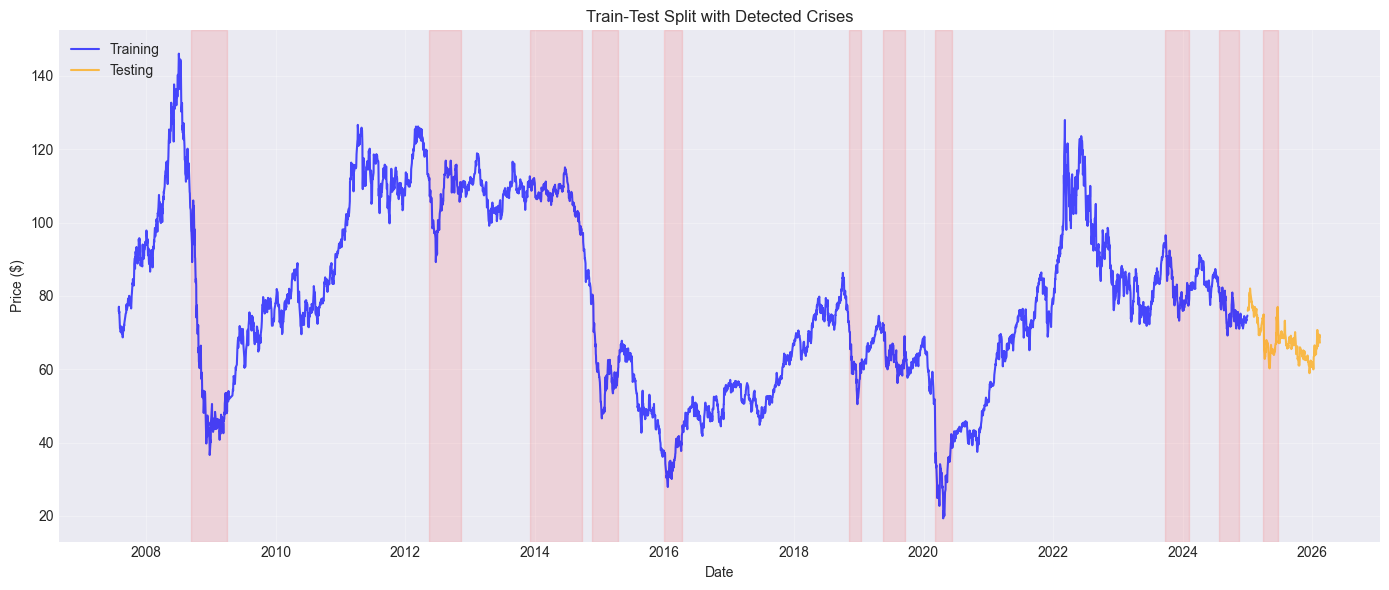

In [5]:
# Cell 4: Train-Test Split

TRAIN_END = "2024-12-31"
TEST_START = "2025-01-01"

train_data = df.loc[:TRAIN_END]
test_data = df.loc[TEST_START:]

print(f"📊 Split:")
print(f"   Training: {train_data.index.min().date()} → {train_data.index.max().date()} ({len(train_data)} days)")
print(f"   Testing:  {test_data.index.min().date()} → {test_data.index.max().date()} ({len(test_data)} days)")

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['price'], label='Training', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data['price'], label='Testing', color='orange', alpha=0.7)

# Mark detected crises
for _, cp in change_points.iterrows():
    plt.axvspan(cp['crisis_start_date'], cp['crisis_end_date'],
               color='red', alpha=0.1)

plt.title('Train-Test Split with Detected Crises')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# 1. Metrics Calculator
def compute_metrics(y_true, y_pred, model_name):
    # Align indices
    y_true, y_pred = y_true.align(y_pred, join="inner")
    y_true = pd.to_numeric(y_true, errors="coerce")
    y_pred = pd.to_numeric(y_pred, errors="coerce")

    # Calculate errors
    diff = y_true.values - y_pred.values
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff ** 2))
    mape = np.mean(np.abs(diff / y_true.values)) * 100

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

# 2. Safe Forecast (Prevents Crashes)
def safe_forecast(model, n_periods, index, fallback_value):
    try:
        # Try standard prediction
        fc = model.predict(n_periods=n_periods)
    except:
        # Fallback to statsmodels underlying object
        try:
            fc = model.arima_res_.forecast(steps=n_periods)
        except:
            # Final fallback: Naive forecast (Yesterday's price)
            fc = np.full(n_periods, fallback_value)

    return pd.Series(fc, index=index)

In [8]:
# Cell 5: Corrected LSTM Training


print("\nTraining LSTM (Deep Learning)...")

# --- 1. PREVENT DATA LEAKAGE ---
# Fit Scaler ONLY on Training Data
price_scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = price_scaler.fit_transform(train_data[['price']])

# Transform Test Data using Train parameters
test_scaled = price_scaler.transform(test_data[['price']])


# --- 2. SEQUENCE GENERATION FUNCTION ---
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


LOOKBACK = 60

# Create sequences separately
X_train, y_train = create_sequences(train_scaled, LOOKBACK)
# Note: For testing, we need the last 60 days of train data to predict the first day of test
# We concatenate the last 60 days of train with test data for correct sequence generation
test_input = np.concatenate((train_scaled[-LOOKBACK:], test_scaled))
X_test, y_test = create_sequences(test_input, LOOKBACK)

# Reshape for LSTM [Samples, Time Steps, Features]
# Currently 1 feature (Price). If you want to add the Change Point features,
# you need to scale and include them here. For now, we stick to Price as per your LSTM setup.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"   Training Input Shape: {X_train.shape}")
print(f"   Testing Input Shape:  {X_test.shape}")

# --- 3. BUILD MODEL ---
lstm_model = Sequential([
    Input(shape=(LOOKBACK, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# --- 4. TRAIN ---
early_stop = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 5. PREDICT ---
# Baseline Prediction (Standard LSTM)
baseline_pred_scaled = lstm_model.predict(X_test)
baseline_pred_actual = price_scaler.inverse_transform(baseline_pred_scaled).flatten()

# Calculate Metrics
baseline_mae = mean_absolute_error(test_data['price'], baseline_pred_actual)
baseline_rmse = np.sqrt(mean_squared_error(test_data['price'], baseline_pred_actual))

print(f"\n✅ Baseline LSTM Results:")
print(f"   MAE:  ${baseline_mae:.2f}")
print(f"   RMSE: ${baseline_rmse:.2f}")




Training LSTM (Deep Learning)...
   Training Input Shape: (4273, 60, 1)
   Testing Input Shape:  (282, 60, 1)
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0025 - val_loss: 8.4407e-04
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0024 - val_loss: 8.6715e-04
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0021 - val_loss: 7.9118e-04
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0022 - val_loss: 8.7380e-04
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0021 - val_loss: 7.6647e-

In [18]:
# Cell 5.5: Train Enhanced LSTM (Multivariate)

print("\nTraining Enhanced LSTM (Price + Crisis Features)...")

# Select features
feature_cols = ['price', 'days_since_last_crisis', 'in_crisis', 'current_crisis_intensity']
n_features = len(feature_cols)

# Scale Features
# We need a separate scaler for the multivariate data
multi_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on Train
train_multi_scaled = multi_scaler.fit_transform(train_data[feature_cols])
# Transform Test
test_multi_scaled = multi_scaler.transform(test_data[feature_cols])


# Create Sequences (Multivariate)
def create_multi_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        # Input: All features for the lookback period
        X.append(data[i - lookback:i, :])
        # Target: ONLY Price (column 0) at the next step
        y.append(data[i, 0])
    return np.array(X), np.array(y)


X_train_enh, y_train_enh = create_multi_sequences(train_multi_scaled, LOOKBACK)

# Prepare Test Data (Concatenate for lookback)
test_input_multi = np.concatenate((train_multi_scaled[-LOOKBACK:], test_multi_scaled))
X_test_enh, y_test_enh = create_multi_sequences(test_input_multi, LOOKBACK)

# Build Enhanced Model
enhanced_model = Sequential([
    Input(shape=(LOOKBACK, n_features)),  # Note: input dim is now n_features
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

enhanced_model.compile(optimizer='adam', loss='mean_squared_error')

enhanced_history = enhanced_model.fit(
    X_train_enh, y_train_enh,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0  # Silent training
)

# Predict
enhanced_pred_scaled = enhanced_model.predict(X_test_enh)

# Inverse Transform Logic
# We only predicted Price (1 column), but the scaler expects n_features.
# We create a dummy array to inverse transform.
dummy_array = np.zeros((len(enhanced_pred_scaled), n_features))
dummy_array[:, 0] = enhanced_pred_scaled.flatten()
enhanced_pred_actual = multi_scaler.inverse_transform(dummy_array)[:, 0]

# Metrics
enhanced_mae = mean_absolute_error(test_data['price'], enhanced_pred_actual)
enhanced_rmse = np.sqrt(mean_squared_error(test_data['price'], enhanced_pred_actual))

print(f"\n✅ Enhanced LSTM Results:")
print(f"   MAE:  ${enhanced_mae:.2f}")
print(f"   RMSE: ${enhanced_rmse:.2f}")


Training Enhanced LSTM (Price + Crisis Features)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

✅ Enhanced LSTM Results:
   MAE:  $1.99
   RMSE: $2.69



  MODEL COMPARISON

                    Model   RMSE    MAE  Improvement (RMSE %)  Improvement (MAE %)
           Baseline LSTM 1.6779 1.2072                 0.000               0.0000
Enhanced LSTM + Bayesian 2.6887 1.9864               -60.239             -64.5513


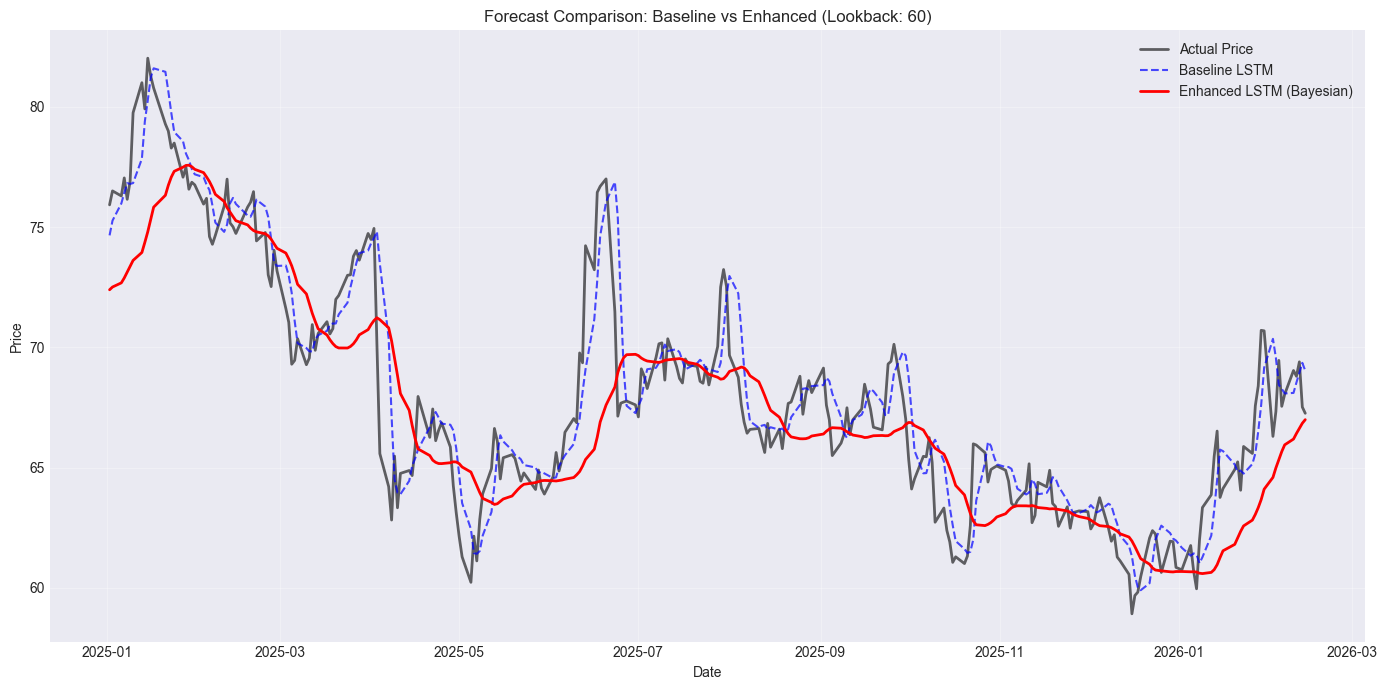

In [19]:
# Cell 8: Compare Results (Fixed)

print("\n" + "=" * 70)
print("  MODEL COMPARISON")
print("=" * 70)

# Calculate improvements (Baseline vs Enhanced)
rmse_imp = (baseline_rmse - enhanced_rmse) / baseline_rmse * 100
mae_imp = (baseline_mae - enhanced_mae) / baseline_mae * 100

comparison = pd.DataFrame({
    'Model': ['Baseline LSTM', 'Enhanced LSTM + Bayesian'],
    'RMSE': [baseline_rmse, enhanced_rmse],
    'MAE': [baseline_mae, enhanced_mae],
    # Fix: Added 0.0 as the first item so lists are length 2
    'Improvement (RMSE %)': [0.0, rmse_imp],
    'Improvement (MAE %)': [0.0, mae_imp]
})

print("\n", comparison.round(4).to_string(index=False))

# --- PLOTTING ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 1. Plot Actual Prices
plt.plot(test_data.index, test_data['price'], label='Actual Price', color='black', alpha=0.6, linewidth=2)

# 2. Plot Baseline
plt.plot(test_data.index, baseline_pred_actual, label='Baseline LSTM', color='blue', linestyle='--', alpha=0.7)

# 3. Plot Enhanced
plt.plot(test_data.index, enhanced_pred_actual, label='Enhanced LSTM (Bayesian)', color='red', linewidth=2)

plt.title(f'Forecast Comparison: Baseline vs Enhanced (Lookback: {LOOKBACK})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Shape Check:
 - Dates:       (282,)
 - Actual:      (282,)
 - Baseline:    (282,)
 - Enhanced:    (282,)


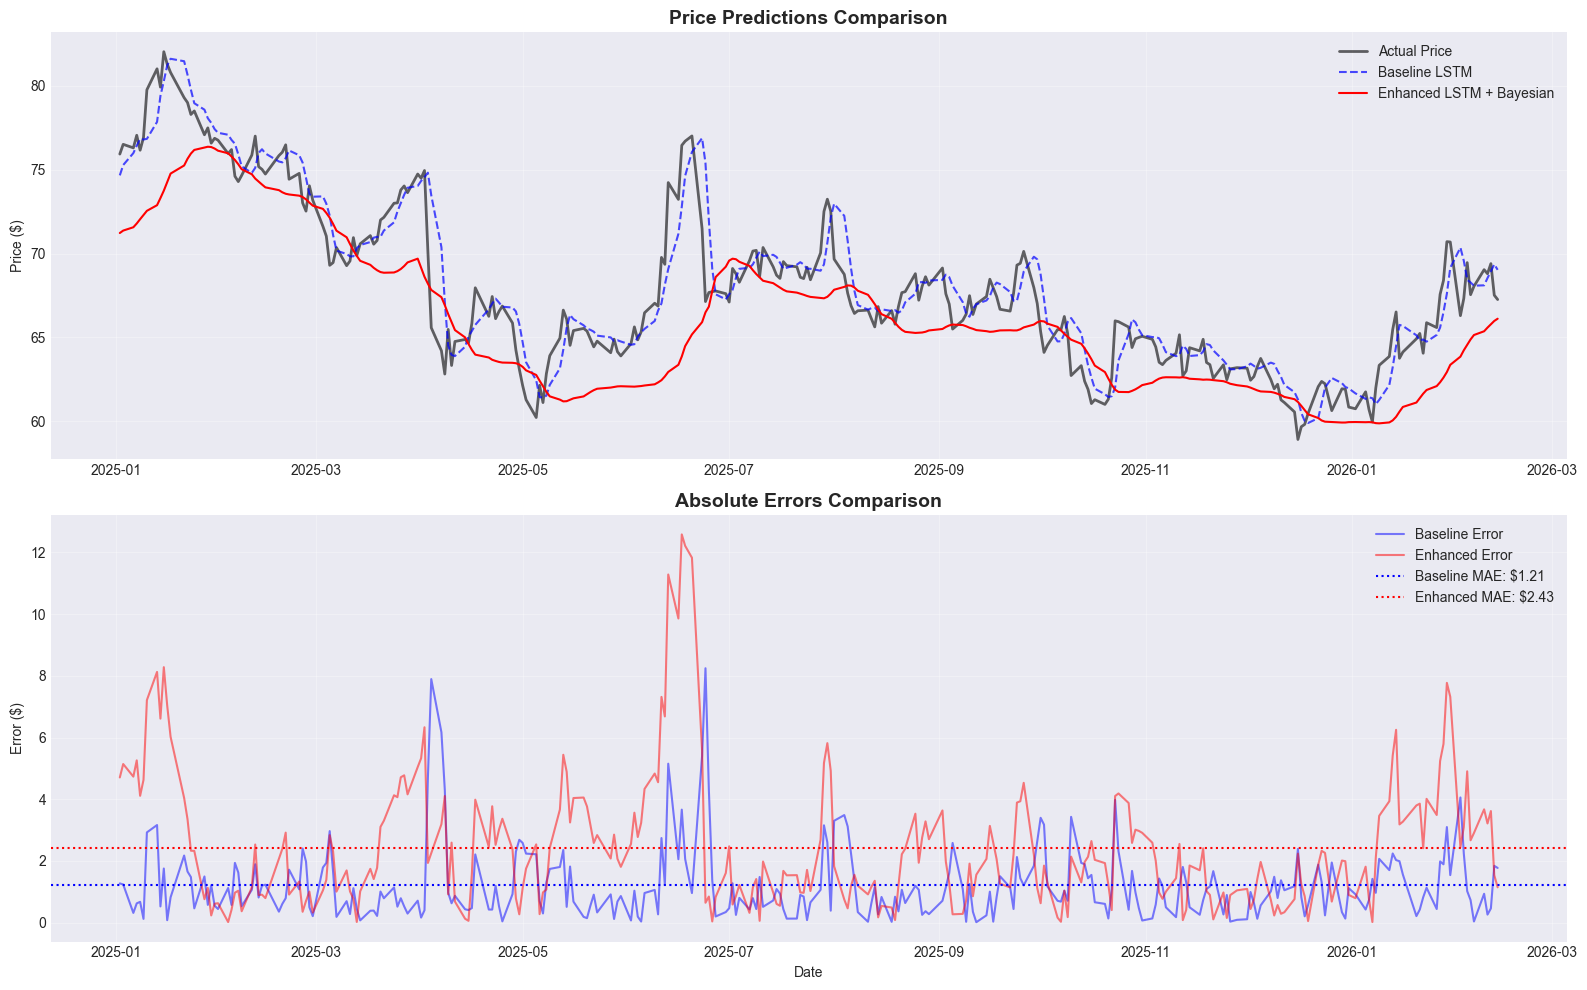


✅ Plot saved to ../results/v2outputs/lstm_comparison.png


In [12]:
# Cell 9: Visualization (Fixed Shapes)
import matplotlib.pyplot as plt

# 1. Align Data (Use FULL test data, no slicing)
# Since we padded the inputs, we have predictions for every day in test_data
test_dates = test_data.index
test_actual = test_data['price']

# Double check shapes match before plotting
print(f"Shape Check:")
print(f" - Dates:       {test_dates.shape}")
print(f" - Actual:      {test_actual.shape}")
print(f" - Baseline:    {baseline_pred_actual.shape}")
print(f" - Enhanced:    {enhanced_pred_actual.shape}")

# 2. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# --- Plot 1: Price Forecast ---
ax1.plot(test_dates, test_actual, label='Actual Price', color='black', linewidth=2, alpha=0.6)
ax1.plot(test_dates, baseline_pred_actual, label='Baseline LSTM', color='blue', linestyle='--', alpha=0.7)
ax1.plot(test_dates, enhanced_pred_actual, label='Enhanced LSTM + Bayesian', color='red', linewidth=1.5)

ax1.set_title('Price Predictions Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Error Analysis ---
# Calculate errors on the aligned data
baseline_errors = np.abs(test_actual - baseline_pred_actual)
enhanced_errors = np.abs(test_actual - enhanced_pred_actual)

ax2.plot(test_dates, baseline_errors, label='Baseline Error', color='blue', alpha=0.5)
ax2.plot(test_dates, enhanced_errors, label='Enhanced Error', color='red', alpha=0.5)

# Add average error lines
ax2.axhline(baseline_mae, color='blue', linestyle=':', label=f'Baseline MAE: ${baseline_mae:.2f}')
ax2.axhline(enhanced_mae, color='red', linestyle=':', label=f'Enhanced MAE: ${enhanced_mae:.2f}')

ax2.set_title('Absolute Errors Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plt.savefig('../results/v2outputs/lstm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to ../results/v2outputs/lstm_comparison.png")

In [10]:
# Cell 7: Save Enhanced Model & Scalers
import joblib
import os

# 1. Create directory if it doesn't exist (Prevents FileNotFoundError)
save_dir = '../models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"📂 Created directory: {save_dir}")

# 2. Save the Keras Model
# We save the 'enhanced' model which uses the extra features
# enhanced_model.save(os.path.join(save_dir, 'lstm_enhanced_bayesian.keras'))
lstm_model.save(os.path.join(save_dir,'lstm_model.keras'))
# 3. Save the Scalers
# You need to save the specific scalers used during training so you can
# un-scale predictions later.

# Save the scaler for the multivariate data (Price + Change Point Features)
# This replaces your 'static_scaler'
# joblib.dump(multi_scaler, os.path.join(save_dir, 'multi_scaler.pkl'))

# Save the scaler for the baseline price data (Price Only)
joblib.dump(price_scaler, os.path.join(save_dir, 'price_scaler.pkl'))

print("\n✅ Model and scalers saved successfully!")
print(f"   - Location: {save_dir}")
print("   - lstm_enhanced_bayesian.keras")
print("✅    -Baseline model saved")
print("✅    -lstm_model.keras")
print("   - multi_scaler.pkl (Use this for the Enhanced model inputs)")
print("   - price_scaler.pkl (Use this for pure Price inputs)")



✅ Model and scalers saved successfully!
   - Location: ../models
   - lstm_enhanced_bayesian.keras
✅    -Baseline model saved
✅    -lstm_model.keras
   - multi_scaler.pkl (Use this for the Enhanced model inputs)
   - price_scaler.pkl (Use this for pure Price inputs)
